change path to image dir

test dataset

data augmentation

cache, prefetch

overfitting

stratergy: simple model first

pipeline

MAE/MSE/RMSE

change lambda regu

### Import

In [1]:
!git clone https://github.com/LapTQ/facial_beauty_perception
%cd facial_beauty_perception/FBP5500/Images

Cloning into 'facial_beauty_perception'...
remote: Enumerating objects: 11230, done.
remote: Counting objects: 100% (11230/11230), done.
remote: Compressing objects: 100% (11215/11215), done.
remote: Total 11230 (delta 136), reused 11033 (delta 12), pack-reused 0
Receiving objects: 100% (11230/11230), 179.09 MiB | 25.40 MiB/s, done.
Resolving deltas: 100% (136/136), done.
Checking out files: 100% (11020/11020), done.
/content/facial_beauty_perception/FBP5500/Images


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, Conv2D, Activation, Add, Input, Dense, ZeroPadding2D, Flatten, AveragePooling2D, MaxPooling2D
from keras.initializers import he_normal
from keras.regularizers import L1, L2
from keras.models import Model

seed = 42

In [3]:
import pathlib
import tempfile
import shutil

from IPython import display

from tensorflow.keras.optimizers import Adam, SGD, Adadelta, RMSprop
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers


### Load images

In [4]:
image_size = (90, 90)
input_shape = (*image_size, 3)
batch_size = 32
scores_path = "https://github.com/LapTQ/facial_beauty_perception/raw/main/FBP5500/train_test_files/All_labels.csv"

scores_dataframe = pd.read_csv(
    scores_path,
    header=None,
    names=['file_name', 'score']
)

scores = scores_dataframe['score'].to_numpy().tolist()

In [5]:
scores_dataframe.head()

,file_name,score
0,AF1.jpg,2.333333
1,AF2.jpg,3.950000
2,AF3.jpg,3.183333
3,AF4.jpg,2.683333
4,AF5.jpg,2.000000


count    5500.000000
mean        2.990891
std         0.688112
min         1.016667
25%         2.500000
50%         2.833333
75%         3.533333
max         4.750000
Name: score, dtype: float64


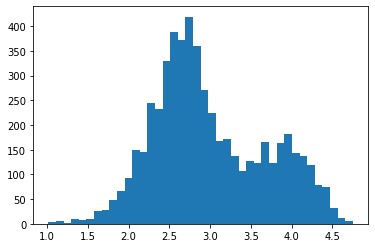

In [6]:
print(scores_dataframe['score'].describe())

plt.hist(scores_dataframe['score'], bins=40,)
plt.show()

In [7]:
images = []
for index in scores_dataframe.index:
    img = image.load_img(scores_dataframe['file_name'][index], target_size=image_size)
    img = image.img_to_array(img)
    images.append(img/255.)

In [8]:
images = np.array(images)
scores = np.array(scores)
np.random.seed(seed)
np.random.shuffle(images)
np.random.seed(seed)
np.random.shuffle(scores)

In [9]:
print(images.shape)
print(scores.shape)

(5500, 90, 90, 3)
(5500,)


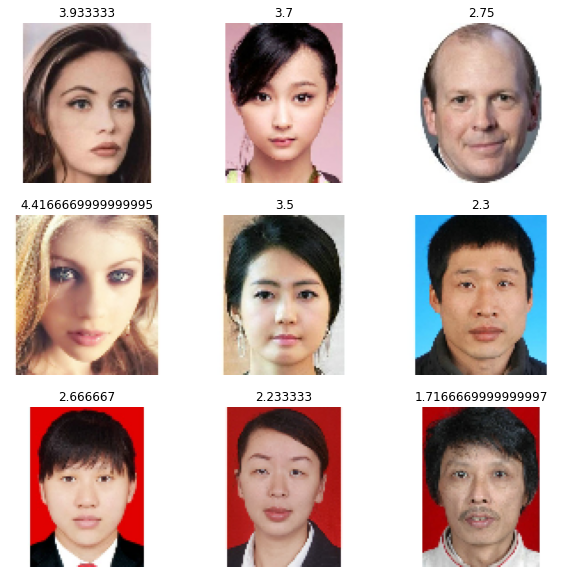

In [10]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(scores[i])
    plt.axis("off")

### Create dataset

In [11]:
n_train = 4400
v_validation = 1100
buffer_size = 5500

In [12]:
images_ds = tf.data.Dataset.from_tensor_slices(images)
scores_ds = tf.data.Dataset.from_tensor_slices(scores)

x_train = images_ds.take(n_train)
x_val = images_ds.skip(n_train)

y_train = scores_ds.take(n_train)
y_val = scores_ds.skip(n_train)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

x_val_prefetch = x_val.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
x_train_prefetch = x_train.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

y_val_prefetch = y_val.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
y_train_prefetch = y_train.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [14]:
ds = tf.data.Dataset.from_tensor_slices((images, scores))

train_ds = ds.take(n_train)
val_ds = ds.skip(n_train)

In [15]:
tiny_val_ds = val_ds.take(5).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
tiny_train_ds = train_ds.take(5).cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [16]:
small_val_ds = val_ds.take(27).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
small_train_ds = train_ds.take(27).cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [17]:
medium_val_ds = val_ds.take(64).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
medium_train_ds = train_ds.take(64).cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [18]:
large_val_ds = val_ds.take(100).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
large_train_ds = train_ds.take(100).cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [19]:
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

### Build architectures

In [20]:
def identity_block(X, f, filters, training=True):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=1, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # add shortcut value to main path and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

    

In [21]:
def convolutional_block(X, f, filters, s=2, training=True):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(F1, kernel_size=1, strides=s, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(F2, kernel_size=f, strides=1, padding='same', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # shortcut path
    X_shortcut = Conv2D(F3, kernel_size=1, strides=s, padding='valid', kernel_initializer=he_normal(seed=seed))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # add shortcut to main path, and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [22]:
def ResNet11(input_shape=(64, 64, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D(padding=3)(X_input)

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256])

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(4, activation='relu', kernel_initializer=he_normal(seed=seed))(X)
    X = Dense(1, kernel_initializer=he_normal(seed=seed))(X)

    # create model
    model = Model(inputs=X_input, outputs=X)

    return model


### Utilities

In [24]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [25]:
patience = 100      # desired
max_epochs = 1000   # desired
steps_per_epoch = n_train//batch_size

In [26]:
def get_callback(name):
    return [tf.keras.callbacks.EarlyStopping(monitor='val_nonregu_mae', patience=patience),
            tf.keras.callbacks.TensorBoard(logdir/name)
            ]

In [27]:
def compile_and_fit(model, optimizer='adam', callbacks=None, train_data=train_ds_prefetch, validation_data=val_ds_prefetch, initial_epoch=0):
    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=[tf.keras.losses.MeanAbsoluteError(
            name='nonregu_mae'
        )]
    )

    np.random.seed(seed)

    history = model.fit(
        train_data,
        steps_per_epoch=steps_per_epoch,
        epochs=max_epochs,
        validation_data=validation_data,
        callbacks=callbacks,
        initial_epoch=initial_epoch
    )

    return history

In [28]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-yh0uwfxn
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-yh0uwfxn
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=157855 sha256=578fbac03e132d663579a3625c98dc6e14c17e3cae350654ab9edf1930225ac9
  Stored in directory: /tmp/pip-ephem-wheel-cache-ep1mde62/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [29]:
plotter = tfdocs.plots.HistoryPlotter(
    metric = 'nonregu_mae',
    smoothing_std=10
)

In [30]:
def loss(model, x, y, training=False):
    mae = tf.keras.losses.MeanAbsoluteError()
    y_pred = model(x, training=training)
    return mae(y_true=y, y_pred=y_pred)

def grad(model, x, y):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, y, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

### Testing

#### plot activation distribution

In [ ]:
model = ResNet11(input_shape)
optimizer = Adam(learning_rate=1e-5)        # try 1e-2 the loss goes up

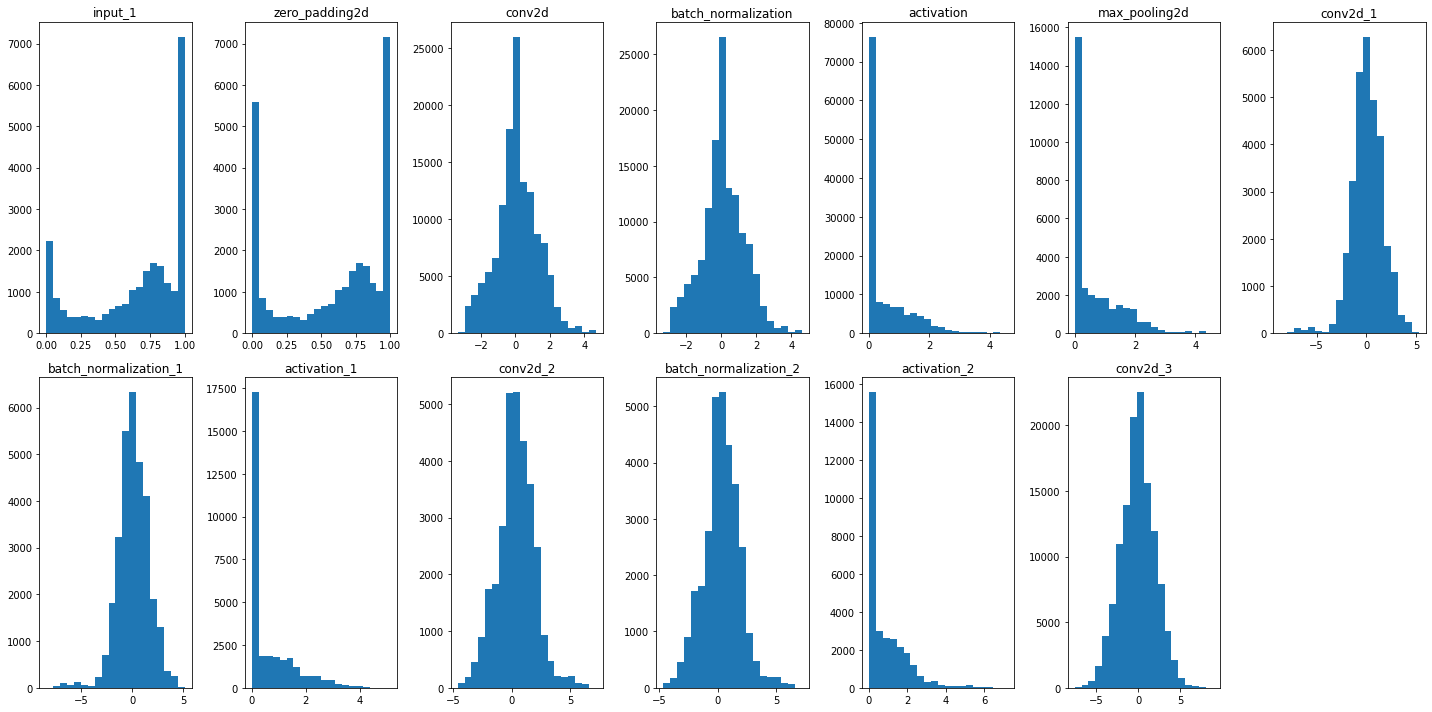

In [ ]:
def plot_activations(model, img):
    """
    Arguments:
        model
        img -- numpy array of shape (height, width, channel)
    """
    activations = [model.layers[0](np.expand_dims(img, axis=0))]      # Input layer
    for layer in model.layers[1:13]:         # 14th layer not match input shape because of shortcut
        # print("Inputing shape: {} to {} with expected input shape: {}".format(activations[-1].shape, layer.name, layer.input_shape))
        activations.append(layer(activations[-1], training=False))

    # plot activation distribution
    plt.figure(figsize=(20, 10))
    for i in range(len(activations)):
        plt.subplot(2, 7, i + 1)
        plt.title(model.layers[i].name)
        plt.tight_layout()
        plt.hist(activations[i].numpy().reshape(-1,), bins=20)

plot_activations(model, images[1])

#### make sure can overfit

In [ ]:
resnet11_histories = {}

In [ ]:
# make sure the model can overfit on very small dataset
model = ResNet11(input_shape)
optimizer = Adam(learning_rate=1e-5)        # try 1e-2 the loss goes up

steps_per_epoch = 5

resnet11_histories['history_11_tiny'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=1e-5),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
)

clearly that the model overfit ;)) so it works

ResNet11 work very well for tiny data set.

Let's try with a small data set.

The loss will be larger (as learning curve) if we keep configuration unchanged (eg. lr).

If we change configuration (eg lr) but cannot get a better loss, than our model might be underfit. So we'll try a bigger model for small dataset

Repeat that

now, let's try with a small data set with Adam

In [ ]:
model = ResNet11(input_shape)

steps_per_epoch = 27

resnet11_histories['history_11_small'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=1e-5),
    train_data=small_train_ds,
    validation_data=small_val_ds
)

Note: figure plotted above

We clearly see that for a bigger dataset,
* the training loss if higher
* the val loss is smaller

=> follow learning curve principle

Let' try with medium dataset

In [ ]:
model = ResNet11(input_shape)

steps_per_epoch = 64

resnet11_histories['history_11_medium'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=5e-6),
    train_data=medium_train_ds,
    validation_data=medium_val_ds
)

still overfit quite well, the training loss even better than for small and tiny, might be because of the smaller leanrning rate

Let' try with large dataset

In [ ]:
model = ResNet11(input_shape)

max_epochs = 20
steps_per_epoch = 100

resnet11_histories['history_11_large'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=5e-6),
    train_data=large_train_ds,
    validation_data=large_val_ds
)

still overfit quite well

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet11_histories['history_11_very_large'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=5e-6),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

full data set seem much worse on train set, but val loss smaller => follow the learning curve

Let's try tuning for a larger lr:

large: 5e-6: slow, 0.3...

lr2: 1e-6: slower, 0.35... vẫn đang đi xuống

lr: 5e-5: slower, 0.4... có dấu hiệu đi lên



có khi xem xét dùng peicewise

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet11_histories['history_11_very_large_tune_lr2'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=1e-6),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

the lr = 5e-6 seems the most optimistic among 3 stratergy.

in the saddle point of training loss plot: 2 reasons:

* reason 1: learning rate is large for that saddle point: Let's try using piecewise constant decay or inverse time decay
* reason 2: saddle point in the obj function: adam, momentum...

combine with training longer

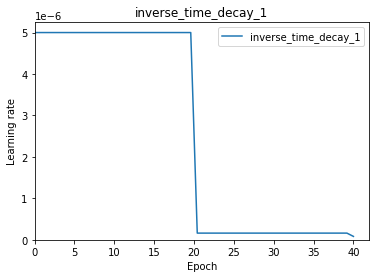

In [ ]:
inverse_time_decay_1 = InverseTimeDecay(
    initial_learning_rate=5e-6,
    decay_steps=steps_per_epoch*20,
    decay_rate=30,
    staircase=True,
    name='inverse_time_decay_1'
)

step = np.linspace(0, steps_per_epoch * max_epochs)

plot_learning_rate(step, inverse_time_decay_1)

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet11_histories['inverse_time_decay_1'] = compile_and_fit(
    model,
    optimizer=Adam(inverse_time_decay_1),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

Text(0.5, 0, 'Epochs')

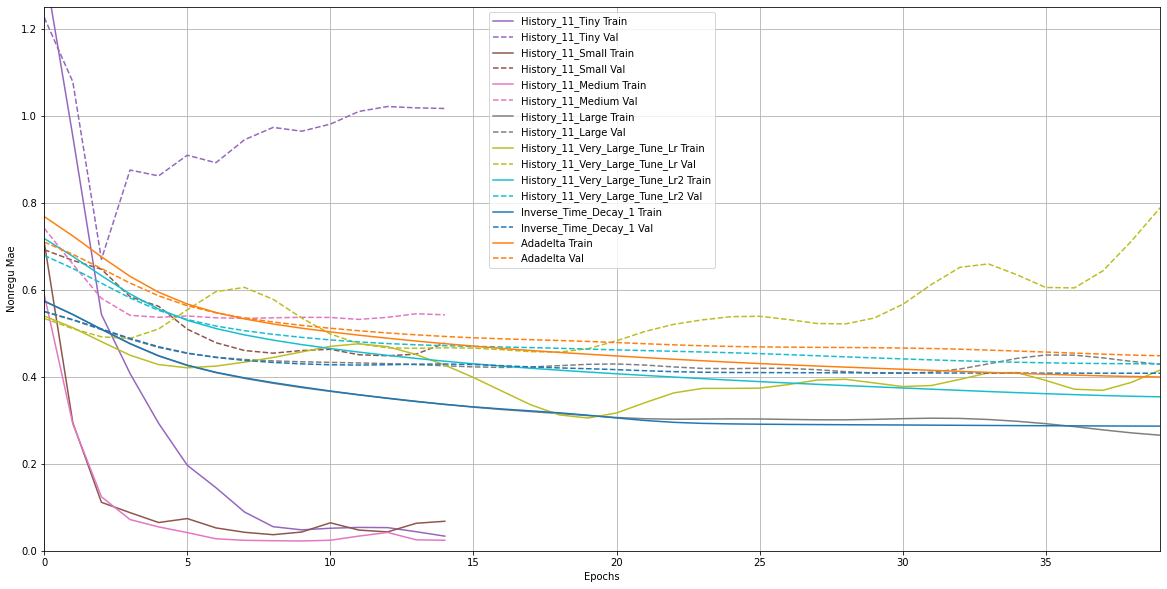

In [ ]:
plt.figure(figsize=(20, 10))
plotter.plot(resnet11_histories)
# a = plt.xscale('log')
plt.xlim([0, max(plt.xlim())])
plt.ylim([0, 1.25])
plt.xlabel('Epochs')        # <---- add [Log scale]

had already tried many cofiguration for inverse tme decay but still not work, let's try other optimization algo

In [ ]:
resnet_11_adadelta_histories = {}

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet_11_adadelta_histories['lr1'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=1e-3),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet_11_adadelta_histories['lr2'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=1e-1),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet_11_adadelta_histories['lr3'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=1e-2),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

In [ ]:
# this one work best
model = ResNet11(input_shape)

max_epochs = 200
steps_per_epoch = 137

resnet_11_adadelta_histories['lr4'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=5e-2),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

In [ ]:
# lr5: continue lr4, but with smaller lr = 5e-3
# model = ResNet11(input_shape)

max_epochs = 100
steps_per_epoch = 137

resnet_11_adadelta_histories['lr5'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=5e-3),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

ohhh, so after 200 epochs of Adadelta with lr = 5e-2, we train on another 100 epochs with lr = 5e-3 show a very optimistic future :))

Text(0.5, 0, 'Epochs')

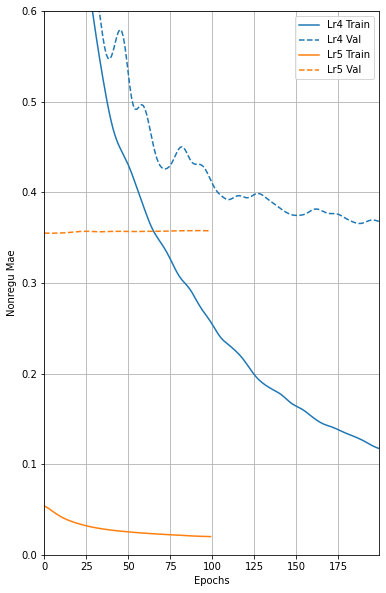

In [ ]:
plt.figure(figsize=(6, 10))
plotter.plot(resnet_11_adadelta_histories)
# a = plt.xscale('log')
# plt.xlim([0, max(plt.xlim())])
plt.ylim([0, 0.6])
plt.xlabel('Epochs')        # <---- add [Log scale]

Now we're confident that the model can overfit the dataset, if I keep training, the loss might be smaller (I GUESS SO :>)

Let's use regularization!!!

#### build regu architecture

In [31]:
l = L2(0.001)

In [32]:
def identity_block_regu(X, f, filters, training=True, dropout_rate=0):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)

    # add shortcut value to main path and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

    

In [33]:
def convolutional_block_regu(X, f, filters, s=2, training=True, dropout_rate=0):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(F1, kernel_size=1, strides=s, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(F2, kernel_size=f, strides=1, padding='same', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(F3, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)

    # shortcut path
    X_shortcut = Conv2D(F3, kernel_size=1, strides=s, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X_shortcut)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # add shortcut to main path, and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [34]:
def ResNet11_regu(input_shape=(64, 64, 3), dropout_rate=0):

    X_input = Input(input_shape)

    X = ZeroPadding2D(padding=3)(X_input)

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block_regu(X, f=3, filters=[64, 64, 256], s=1, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[64, 64, 256], dropout_rate=dropout_rate)

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(4, activation='relu', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = Dense(1, kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)

    # create model
    model = Model(inputs=X_input, outputs=X)

    return model


#### testing

In [ ]:
# Testing learning rate
l = L2(0.001)

# model without dropout
model = ResNet11_regu(input_shape)

optimizer = Adadelta(learning_rate=1e-2)


loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

2.3670883
1.2978877
0.7346019


In [ ]:
# check if the regu term is present

model.layers[2].get_config()

first, we check with tiny dataset

if the training is terminated because of callback, adjust the learning rate to smaller



In [ ]:
l = L2(0.001)

patience = 10
max_epochs = 20
steps_per_epoch = 5


lr = 1e-4
name = 'regu_0.001_adadelta_{}_tiny'.format(lr)
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
    callbacks=get_callback('optimizers/' + name)
)

plotter.plot({name: history})
plt.xlabel('Epochs')        # <---- add [Log scale]

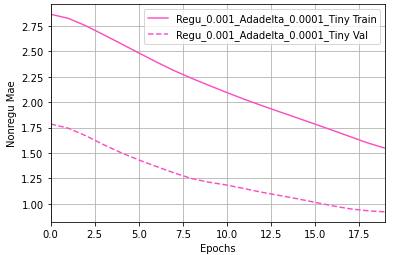

với 20 epochs fit khá tốt với tiny. nếu train thêm chắc sẽ overfit được

#### thử xem model gốc có overfit được toàn bộ tập data không

In [94]:
batch_size = 64
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [95]:
resnet_11_histories = {}

In [ ]:
patience = 10   # 10?
max_epochs = 20
steps_per_epoch = n_train // batch_size

l = None
lr = 5e-4
name = 'adadelta_lr_{}'.format(lr)


shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

resnet_11_histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    # callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [resnet_11_histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

In [ ]:
patience = 30
max_epochs = 40

lr = 5e-6

shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)

cont_history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    # callbacks=get_callback('optimizers/' + name),
    initial_epoch=resnet_11_histories[name].epoch[-1]
)

epoch_record.append(cont_history.epoch[-1])
lr_record.append(lr)
resnet_11_histories[name].epoch += cont_history.epoch
resnet_11_histories[name].history['loss'] += cont_history.history['loss']
resnet_11_histories[name].history['val_loss'] += cont_history.history['val_loss']
resnet_11_histories[name].history['nonregu_mae'] += cont_history.history['nonregu_mae']
resnet_11_histories[name].history['val_nonregu_mae'] += cont_history.history['val_nonregu_mae']

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

Text(0.5, 0, 'Epochs')

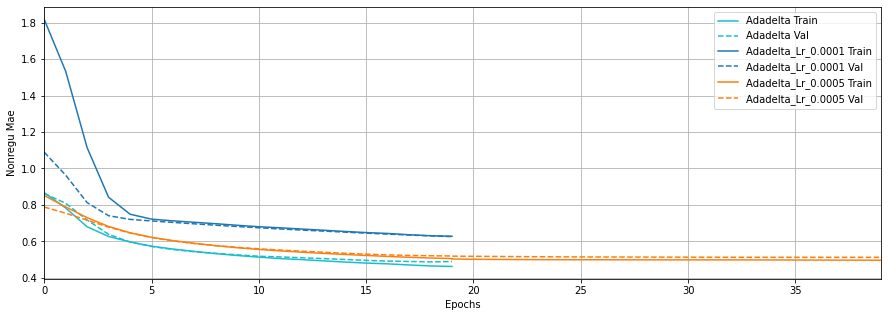

In [116]:
plt.figure(figsize=(15, 5))
plotter.plot(resnet_11_histories)
# for i in range(len(epoch_record) - 1):
#     plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

thay đổi lr không có ích gì, thử đổi sang optiizer khác xem sao

#### thử với lamda = 0.001

In [ ]:
resnet_11_regu_histories = {}

In [ ]:
l = L2(0.001)

patience = 10
max_epochs = 50
steps_per_epoch = 137

lr = 1e-4


name = 'regu_0.001_adadelta'
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

resnet_11_regu_histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [resnet_11_regu_histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

In [ ]:
patience = 30
max_epochs = 400

lr = 1e-4


# shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)

cont_history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name),
    initial_epoch=resnet_11_regu_histories[name].epoch[-1]
)

lr_record.append(lr)
epoch_record.append(cont_history.epoch[-1])
resnet_11_regu_histories[name].epoch += cont_history.epoch
resnet_11_regu_histories[name].history['loss'] += cont_history.history['loss']
resnet_11_regu_histories[name].history['val_loss'] += cont_history.history['val_loss']
resnet_11_regu_histories[name].history['nonregu_mae'] += cont_history.history['nonregu_mae']
resnet_11_regu_histories[name].history['val_nonregu_mae'] += cont_history.history['val_nonregu_mae']

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

Text(0.5, 0, 'Epochs')

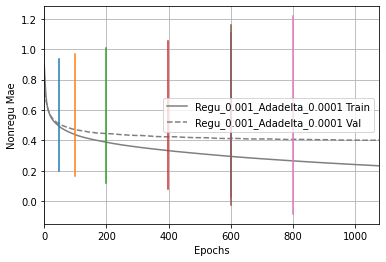

In [ ]:
# plt.figure(figsize=(15, 5))
plotter.plot(resnet_11_regu_histories)
for i in range(len(epoch_record) - 1):
    plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

có vẻ không ổn lắm vì khoảng cách bắt đầu xa

#### Thử với lambda = 0.01

In [ ]:
batch_size = 64
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Testing learning rate
l = L2(0.01)

# model without dropout
model = ResNet11_regu(input_shape)

optimizer = Adadelta(learning_rate=1e-2)

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

2.3670883
1.2978876
0.73460203


try overfit on tiny

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
5/5 [==============================] - 4s 466ms/step - loss: 24.5259 - nonregu_mae: 2.5810 - val_loss: 23.3164 - val_nonregu_mae: 1.3717
Epoch 2/20
5/5 [==============================] - 1s 269ms/step - loss: 23.8404 - nonregu_mae: 1.8958 - val_loss: 22.8131 - val_nonregu_mae: 0.8686
Epoch 3/20
5/5 [==============================] - 1s 271ms/step - loss: 23.2852 - nonregu_mae: 1.3408 - val_loss: 22.5252 - val_nonregu_mae: 0.5810
Epoch 4/20
5/5 [==============================] - 1s 266ms/step - loss: 22.7732 - nonregu_mae: 0.8291 - val_loss: 22.4501 - val_nonregu_mae: 0.5062
Epoch 5/20
5/5 [==============================] - 1s 260ms/step - loss: 22.5949 - nonregu_mae: 0.6512 - val_loss: 22.5185 - val_nonregu_mae: 0.5750
Epoch 6/20
5/5 [==============================] - 1s 262ms/step - loss: 22.4983 - nonregu_mae: 0.5550 - val_loss: 22.5787 - val_nonregu_mae: 0.6357
Epoch 7/20
5/5 [==============================] - 1s 259ms/step - loss: 22.4012 - nonregu_mae: 0.4584 - val_loss

Text(0.5, 0, 'Epochs')

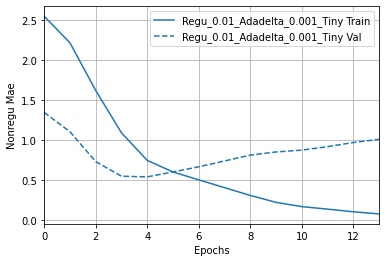

In [ ]:
l = L2(0.01)

patience = 10
max_epochs = 20
steps_per_epoch = 5

lr = 1e-3

name = 'regu_0.01_adadelta_{}_tiny'.format(lr)
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
    callbacks=get_callback('optimizers/' + name)
)

plotter.plot({name: history})
plt.xlabel('Epochs')        # <---- add [Log scale]

In [ ]:
# resnet_11_regu_histories = {}

In [ ]:
l = L2(0.01)

patience = 10
max_epochs = 50
steps_per_epoch = n_train // batch_size

lr = 1e-3


name = 'regu_0.01_adadelta'
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

resnet_11_regu_histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [resnet_11_regu_histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

Text(0.5, 0, 'Epochs')

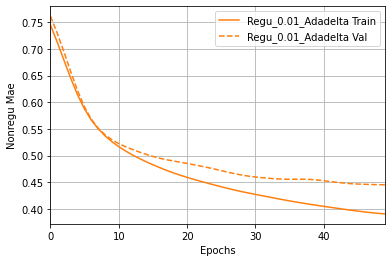

In [ ]:
# plt.figure(figsize=(15, 5))
plotter.plot(resnet_11_regu_histories)
for i in range(len(epoch_record) - 1):
    plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

lambda = 0.01 trông vẫn tệ, thử cái lớn hơn xem sao

#### thử lambda = 0.1

In [ ]:
batch_size = 64
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Testing learning rate
l = L2(0.1)

# model without dropout
model = ResNet11_regu(input_shape)

optimizer = Adadelta(learning_rate=1e-2)

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

2.3670883
1.2978877
0.73460186


try overfit on tiny

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
5/5 [==============================] - 4s 472ms/step - loss: 222.0275 - nonregu_mae: 2.5825 - val_loss: 220.8102 - val_nonregu_mae: 1.3724
Epoch 2/20
5/5 [==============================] - 1s 263ms/step - loss: 221.3324 - nonregu_mae: 1.9000 - val_loss: 220.2935 - val_nonregu_mae: 0.8694
Epoch 3/20
5/5 [==============================] - 1s 267ms/step - loss: 220.7667 - nonregu_mae: 1.3483 - val_loss: 219.9922 - val_nonregu_mae: 0.5824
Epoch 4/20
5/5 [==============================] - 1s 263ms/step - loss: 220.2397 - nonregu_mae: 0.8358 - val_loss: 219.9009 - val_nonregu_mae: 0.5066
Epoch 5/20
5/5 [==============================] - 1s 262ms/step - loss: 220.0424 - nonregu_mae: 0.6548 - val_loss: 219.9508 - val_nonregu_mae: 0.5734
Epoch 6/20
5/5 [==============================] - 1s 257ms/step - loss: 219.9300 - nonregu_mae: 0.5595 - val_loss: 219.9937 - val_nonregu_mae: 0.6335
Epoch 7/20
5/5 [==============================] - 1s 263ms/step - loss: 219.8182 - nonregu_mae: 0.46

Text(0.5, 0, 'Epochs')

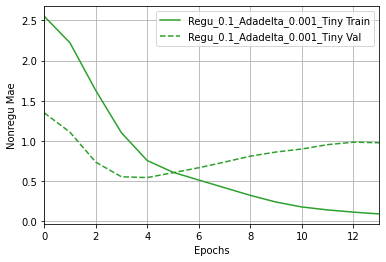

In [ ]:
l = L2(0.1)

patience = 10
max_epochs = 20
steps_per_epoch = 5

lr = 1e-3

name = 'regu_0.1_adadelta_{}_tiny'.format(lr)
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
    callbacks=get_callback('optimizers/' + name)
)

plotter.plot({name: history})
plt.xlabel('Epochs')        # <---- add [Log scale]

In [ ]:
# resnet_11_regu_histories = {}

In [ ]:
patience = 10
max_epochs = 50
steps_per_epoch = n_train // batch_size

l = L2(0.1)
name = 'regu_0.1_adadelta'
lr = 1e-3


shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

resnet_11_regu_histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [resnet_11_regu_histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

Text(0.5, 0, 'Epochs')

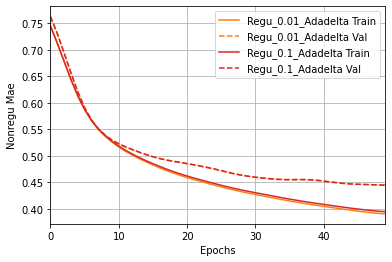

In [ ]:
# plt.figure(figsize=(15, 5))
plotter.plot(resnet_11_regu_histories)
for i in range(len(epoch_record) - 1):
    plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

#### thử lambda = 1

In [ ]:
batch_size = 64
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Testing learning rate
l = L2(1)

# model without dropout
model = ResNet11_regu(input_shape)

optimizer = Adadelta(learning_rate=1e-2)

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

2.3670883
1.2978876
0.734602


try overfit on tiny

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
5/5 [==============================] - 4s 481ms/step - loss: 2197.0098 - nonregu_mae: 2.5906 - val_loss: 2195.6785 - val_nonregu_mae: 1.3766
Epoch 2/20
5/5 [==============================] - 1s 264ms/step - loss: 2196.1431 - nonregu_mae: 1.9219 - val_loss: 2194.9719 - val_nonregu_mae: 0.8734
Epoch 3/20
5/5 [==============================] - 1s 265ms/step - loss: 2195.4121 - nonregu_mae: 1.3962 - val_loss: 2194.4854 - val_nonregu_mae: 0.5944
Epoch 4/20
5/5 [==============================] - 1s 263ms/step - loss: 2194.6990 - nonregu_mae: 0.8922 - val_loss: 2194.1768 - val_nonregu_mae: 0.4971
Epoch 5/20
5/5 [==============================] - 1s 266ms/step - loss: 2194.2651 - nonregu_mae: 0.6724 - val_loss: 2194.0388 - val_nonregu_mae: 0.5776
Epoch 6/20
5/5 [==============================] - 1s 260ms/step - loss: 2193.9602 - nonregu_mae: 0.5876 - val_loss: 2193.8801 - val_nonregu_mae: 0.6405
Epoch 7/20
5/5 [==============================] - 1s 263ms/step - loss: 2193.6543 - nonr

Text(0.5, 0, 'Epochs')

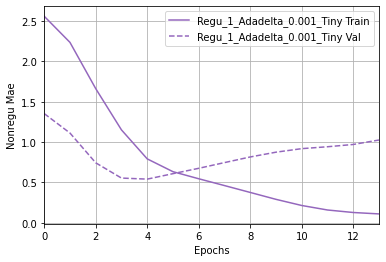

In [ ]:
l = L2(1)

patience = 10
max_epochs = 20
steps_per_epoch = 5

lr = 1e-3

name = 'regu_1_adadelta_{}_tiny'.format(lr)
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
    callbacks=get_callback('optimizers/' + name)
)

plotter.plot({name: history})
plt.xlabel('Epochs')        # <---- add [Log scale]

In [ ]:
# resnet_11_regu_histories = {}

In [ ]:
patience = 10
max_epochs = 50
steps_per_epoch = n_train // batch_size

l = L2(1)
name = 'regu_1_adadelta'
lr = 1e-3

shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

resnet_11_regu_histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [resnet_11_regu_histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

Text(0.5, 0, 'Epochs')

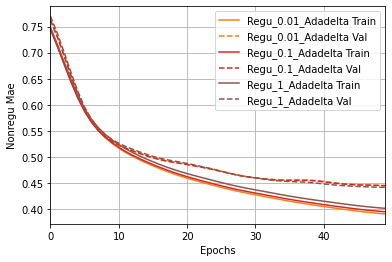

In [ ]:
# plt.figure(figsize=(15, 5))
plotter.plot(resnet_11_regu_histories)
for i in range(len(epoch_record) - 1):
    plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

sao tệ thế nhỉ, thử dropout xem sao

#### thử dropout + L2

In [ ]:
l = L2(0.01)

model = ResNet11_regu(input_shape, dropout_rate=0.5)

optimizer = Adadelta(learning_rate=1e-2)

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

2.4328966
1.9771545
1.9397348


try overfit on tiny

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
5/5 [==============================] - 4s 466ms/step - loss: 3.0556 - nonregu_mae: 3.0556 - val_loss: 1.5270 - val_nonregu_mae: 1.5270
Epoch 2/20
5/5 [==============================] - 1s 272ms/step - loss: 2.8212 - nonregu_mae: 2.8212 - val_loss: 1.1424 - val_nonregu_mae: 1.1424
Epoch 3/20
5/5 [==============================] - 1s 274ms/step - loss: 2.6440 - nonregu_mae: 2.6440 - val_loss: 0.8369 - val_nonregu_mae: 0.8369
Epoch 4/20
5/5 [==============================] - 1s 273ms/step - loss: 2.4692 - nonregu_mae: 2.4692 - val_loss: 0.7163 - val_nonregu_mae: 0.7163
Epoch 5/20
5/5 [==============================] - 1s 280ms/step - loss: 2.1561 - nonregu_mae: 2.1561 - val_loss: 0.6747 - val_nonregu_mae: 0.6747
Epoch 6/20
5/5 [==============================] - 1s 272ms/step - loss: 2.1896 - nonregu_mae: 2.1896 - val_loss: 0.6490 - val_nonregu_mae: 0.6490
Epoch 7/20
5/5 [==============================] - 1s 272ms/step - loss: 2.1380 - nonregu_mae: 2.1380 - val_loss: 0.6290 - va

Text(0.5, 0, 'Epochs')

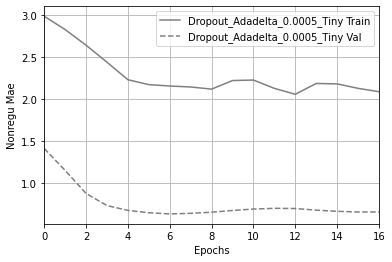

In [ ]:
l = L2(0.01)

patience = 10
max_epochs = 20
steps_per_epoch = 5

lr = 5e-4

name = 'dropout_adadelta_{}_tiny'.format(lr)
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape, dropout_rate=0.5)

history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
    callbacks=get_callback('optimizers/' + name)
)

plotter.plot({name: history})
plt.xlabel('Epochs')        # <---- add [Log scale]

In [ ]:
batch_size = 64
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# resnet_11_regu_histories = {}

In [ ]:
patience = 125   # 10?
max_epochs = 700
steps_per_epoch = n_train // batch_size

l = L2(0.01)
name = 'dropout_0.01_adadelta'
lr = 5e-2


shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape, dropout_rate=0.5)

resnet_11_regu_histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [resnet_11_regu_histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

In [ ]:
patience = 30
max_epochs = 900

lr = 1e-1

shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)

cont_history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name),
    initial_epoch=resnet_11_regu_histories[name].epoch[-1]
)

epoch_record.append(cont_history.epoch[-1])
lr_record.append(lr)
resnet_11_regu_histories[name].epoch += cont_history.epoch
resnet_11_regu_histories[name].history['loss'] += cont_history.history['loss']
resnet_11_regu_histories[name].history['val_loss'] += cont_history.history['val_loss']
resnet_11_regu_histories[name].history['nonregu_mae'] += cont_history.history['nonregu_mae']
resnet_11_regu_histories[name].history['val_nonregu_mae'] += cont_history.history['val_nonregu_mae']

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

nguyên nhân:

* lr lớn, cần giảm ===> đã thử lr bé rất nhiều nhưng không thể hạ thấp hơn đc
* saddle point
* model capacity

thử dùng giải thuật khác xem sao

[0.05, 0.001, 1e-06, 0.1]


Text(0.5, 0, 'Epochs')

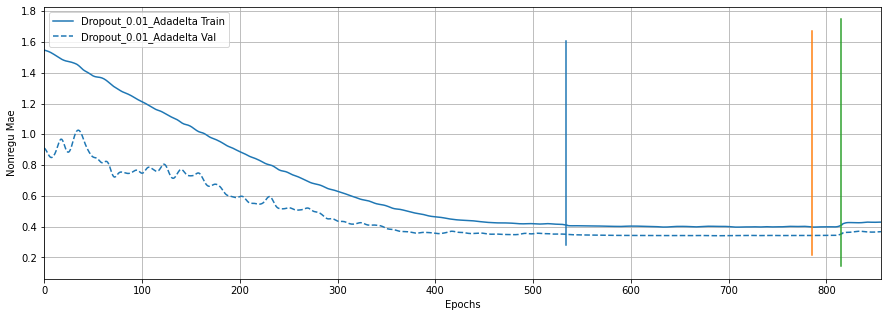

In [ ]:
print(lr_record)

plt.figure(figsize=(15, 5))
plotter.plot(resnet_11_regu_histories)
for i in range(len(epoch_record) - 1):
    plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

thay đổi lr không có ích gì, thử đổi sang optiizer khác xem sao

#### Thử optimizer khác

In [ ]:
l = None

model = ResNet11_regu(input_shape, dropout_rate=0.5)

optimizer = Adam(learning_rate=5e-6)

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

2.4097083
2.1788325
2.0539768


In [ ]:
batch_size = 64
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
resnet_11_regu_histories = {}

In [ ]:
from tensorflow.keras.optimizers import Nadam

In [ ]:
def coarse(optimizer):
    name = optimizer.get_config()['name'] + '_' + str(optimizer.get_config()['learning_rate'])

    shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
    model = ResNet11_regu(input_shape, dropout_rate=0.5)

    l = L2(0.01)

    resnet_11_regu_histories[name] = compile_and_fit(
        model,
        optimizer=optimizer,
        callbacks=get_callback('optimizers/' + name)
    )

patience = 100
max_epochs = 200
steps_per_epoch = n_train // batch_size

In [ ]:
coarse(Adam(learning_rate=1e-4))

In [ ]:
coarse(Adam(learning_rate=5e-5))

In [ ]:
coarse(Adam(learning_rate=1e-5))

[5e-05]


Text(0.5, 0, 'Epochs')

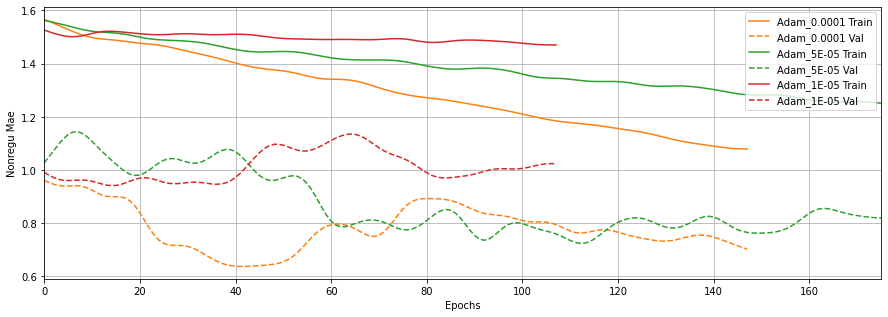

In [ ]:
plt.figure(figsize=(15, 5))
plotter.plot(resnet_11_regu_histories)
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

In [ ]:
coarse(SGD(learning_rate=5e-5, nesterov=True))

In [ ]:
coarse(SGD(learning_rate=1e-5, nesterov=True))

In [ ]:
coarse(SGD(learning_rate=5e-6, nesterov=True))

In [ ]:
coarse(SGD(learning_rate=1e-6, nesterov=True))

[5e-05]


Text(0.5, 0, 'Epochs')

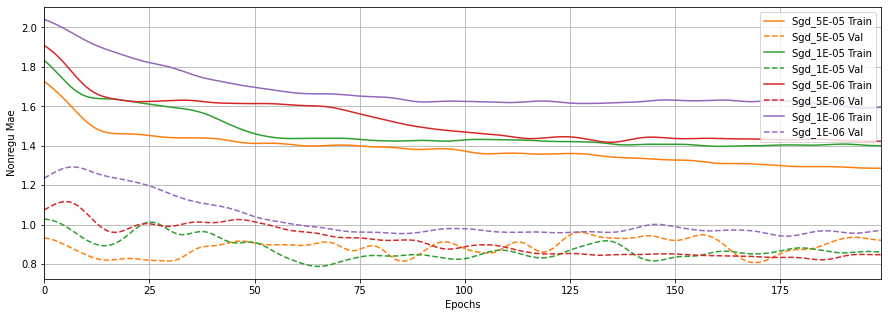

In [ ]:
plt.figure(figsize=(15, 5))
plotter.plot(resnet_11_regu_histories)
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

In [ ]:
coarse(Nadam(learning_rate=5e-4))

In [ ]:
coarse(Nadam(learning_rate=5e-5))

In [ ]:
coarse(Nadam(learning_rate=5e-6))

Text(0.5, 0, 'Epochs')

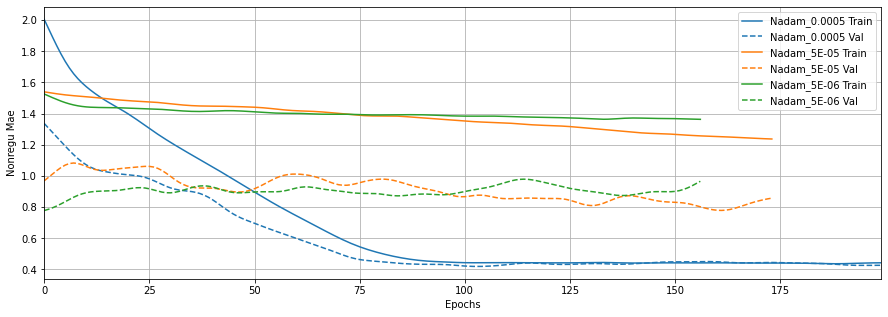

In [ ]:
plt.figure(figsize=(15, 5))
plotter.plot(resnet_11_regu_histories)
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

In [ ]:
coarse(Adam(learning_rate=5e-4))

In [ ]:
coarse(Adam(learning_rate=1e-3))

Text(0.5, 0, 'Epochs')

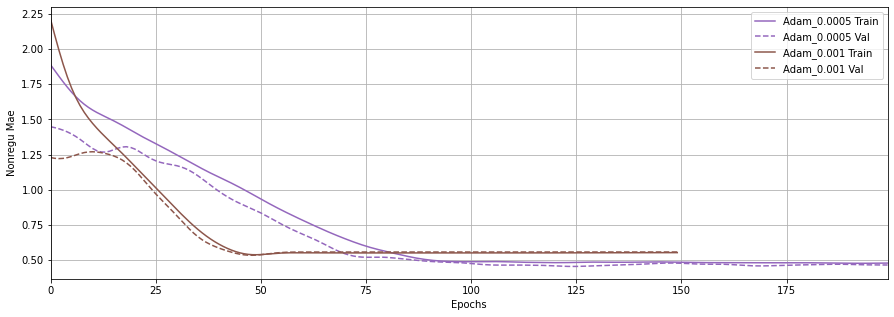

In [ ]:
plt.figure(figsize=(15, 5))
plotter.plot(resnet_11_regu_histories)
for i in range(len(epoch_record) - 1):
    plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

All 4 optimizing algorithms couldn't beat the 0.4 threshold, so might be the model capacity should be larger

?????? đã kiểm tra xem cân đối giữa regu loss và example loss chưa? biết đâu cái regu bị lớn quá thì sao?

Check correlation, biết đâu cái loss tổng vấn giảm tốt nhưng chỉ vì nó quá trú tâm vào regu loss???

#### thử giảm lambda của resnet11

In [ ]:
patience = 30   # 10?
max_epochs = 700
steps_per_epoch = n_train // batch_size

l = L2(0.001)
name = 'dropout_0.001_adadelta'
lr = 1e-0


shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape, dropout_rate=0.5)

resnet_11_regu_histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [resnet_11_regu_histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

In [ ]:
patience = 30
max_epochs = 700

lr = 1e-2

shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)

cont_history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name),
    initial_epoch=resnet_11_regu_histories[name].epoch[-1]
)

epoch_record.append(cont_history.epoch[-1])
lr_record.append(lr)
resnet_11_regu_histories[name].epoch += cont_history.epoch
resnet_11_regu_histories[name].history['loss'] += cont_history.history['loss']
resnet_11_regu_histories[name].history['val_loss'] += cont_history.history['val_loss']
resnet_11_regu_histories[name].history['nonregu_mae'] += cont_history.history['nonregu_mae']
resnet_11_regu_histories[name].history['val_nonregu_mae'] += cont_history.history['val_nonregu_mae']

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

[1.0, 0.1, 0.01]


Text(0.5, 0, 'Epochs')

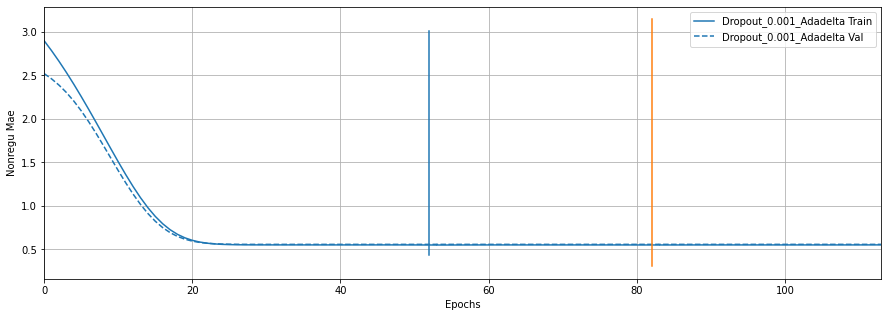

In [ ]:
print(lr_record)

plt.figure(figsize=(15, 5))
plotter.plot(resnet_11_regu_histories)
for i in range(len(epoch_record) - 1):
    plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

haizzz vẫn không qua được mức 0.4

#### Deeper net

In [37]:
def ResNet50(input_shape=(64, 64, 3), dropout_rate=0):

    X_input = Input(input_shape)

    X = ZeroPadding2D(padding=3)(X_input)

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block_regu(X, f=3, filters=[64, 64, 256], s=1, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[64, 64, 256], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[64, 64, 256], dropout_rate=dropout_rate)

    # stage 3
    X = convolutional_block_regu(X, f=3, filters=[128, 128, 512], s=2, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[128, 128, 512], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[128, 128, 512], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[128, 128, 512], dropout_rate=dropout_rate)

    # stage 4
    X = convolutional_block_regu(X, f=3, filters=[256, 256, 1024], s=2, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], dropout_rate=dropout_rate)

    # stage 5
    X = convolutional_block_regu(X, f=3, filters=[512, 512, 2048], s=2, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[512, 512, 2048], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[512, 512, 2048], dropout_rate=dropout_rate)

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(4, activation='relu', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = Dense(1, kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)

    # create model
    model = Model(inputs=X_input, outputs=X)

    return model

#### thử overfit

In [117]:
batch_size = 64
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [118]:
resnet_50_histories = {}

In [126]:
patience = 30   # 10?
max_epochs = 40
steps_per_epoch = n_train // batch_size

l = None
lr = 5e-3
name = 'resnet_50_adadelta_lr_{}'.format(lr)


shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet50(input_shape)

resnet_50_histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    # callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [resnet_50_histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

Epoch 1/40
68/68 [==============================] - 26s 265ms/step - loss: 0.8364 - nonregu_mae: 0.8364 - val_loss: 0.7373 - val_nonregu_mae: 0.7350
Epoch 2/40
68/68 [==============================] - 17s 244ms/step - loss: 0.7076 - nonregu_mae: 0.7076 - val_loss: 0.7026 - val_nonregu_mae: 0.6995
Epoch 3/40
68/68 [==============================] - 17s 245ms/step - loss: 0.6611 - nonregu_mae: 0.6611 - val_loss: 0.6861 - val_nonregu_mae: 0.6846
Epoch 4/40
68/68 [==============================] - 17s 245ms/step - loss: 0.6635 - nonregu_mae: 0.6635 - val_loss: 0.6717 - val_nonregu_mae: 0.6695
Epoch 5/40
68/68 [==============================] - 17s 244ms/step - loss: 0.5201 - nonregu_mae: 0.5201 - val_loss: 0.6792 - val_nonregu_mae: 0.6743
Epoch 6/40
68/68 [==============================] - 17s 245ms/step - loss: 0.4619 - nonregu_mae: 0.4619 - val_loss: 0.6606 - val_nonregu_mae: 0.6573
Epoch 7/40
68/68 [==============================] - 17s 244ms/step - loss: 0.4238 - nonregu_mae: 0.4238 - 

'/content/facial_beauty_perception/saved_model.zip'

Text(0.5, 0, 'Epochs')

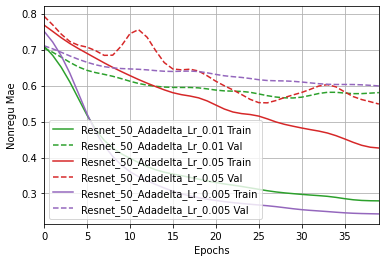

In [127]:
# plt.figure(figsize=(15, 5))
plotter.plot(resnet_50_histories)
for i in range(len(epoch_record) - 1):
    plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

In [ ]:
patience = 10
max_epochs = 60

lr = 5e-5

shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)

cont_history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    # callbacks=get_callback('optimizers/' + name),
    initial_epoch=resnet_50_histories[name].epoch[-1]
)

epoch_record.append(cont_history.epoch[-1])
lr_record.append(lr)
resnet_50_histories[name].epoch += cont_history.epoch
resnet_50_histories[name].history['loss'] += cont_history.history['loss']
resnet_50_histories[name].history['val_loss'] += cont_history.history['val_loss']
resnet_50_histories[name].history['nonregu_mae'] += cont_history.history['nonregu_mae']
resnet_50_histories[name].history['val_nonregu_mae'] += cont_history.history['val_nonregu_mae']

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

#### thử resnet với regu

In [46]:
l = L2(0.01)

# model dropout
model = ResNet50(input_shape, dropout_rate=0.5)

optimizer = Adadelta(learning_rate=5e-2)

loss_value, gradients = grad(model, images[:64], scores[:64])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:64], scores[:64])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:64], scores[:64])

print(loss_value.numpy())

2.8561416
2.1024299
1.9927382


try overfit on tiny

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/40
5/5 [==============================] - 11s 1s/step - loss: 2.1690 - nonregu_mae: 2.1690 - val_loss: 1.7561 - val_nonregu_mae: 1.7561
Epoch 2/40
5/5 [==============================] - 2s 406ms/step - loss: 1.9614 - nonregu_mae: 1.9614 - val_loss: 2.1608 - val_nonregu_mae: 2.1608
Epoch 3/40
5/5 [==============================] - 2s 401ms/step - loss: 1.7601 - nonregu_mae: 1.7601 - val_loss: 2.3098 - val_nonregu_mae: 2.3098
Epoch 4/40
5/5 [==============================] - 2s 411ms/step - loss: 1.5801 - nonregu_mae: 1.5801 - val_loss: 2.5750 - val_nonregu_mae: 2.5750
Epoch 5/40
5/5 [==============================] - 2s 412ms/step - loss: 1.4402 - nonregu_mae: 1.4402 - val_loss: 2.3304 - val_nonregu_mae: 2.3304
Epoch 6/40
5/5 [==============================] - 2s 410ms/step - loss: 1.3095 - nonregu_mae: 1.3095 - val_loss: 1.7885 - val_nonregu_mae: 1.7885
Epoch 7/40
5/5 [==============================] - 2s 397ms/step - loss: 1.1886 - nonregu_mae: 1.1886 - val_loss: 1.3859 - val_

Text(0.5, 0, 'Epochs')

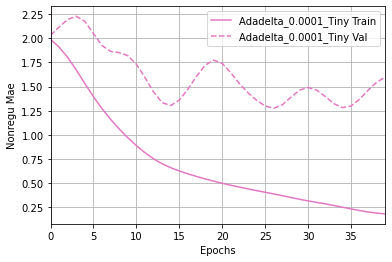

In [55]:
patience = 40
max_epochs = 40
steps_per_epoch = 5

lr = 1e-4
l = None

name = 'resnet_50_adadelta_{}_tiny'.format(lr)
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet50(input_shape) #, dropout_rate=0.5)

history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
    callbacks=get_callback('optimizers/' + name)
)

plotter.plot({name: history})
plt.xlabel('Epochs')        # <---- add [Log scale]

In [56]:
batch_size = 64
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [57]:
resnet_50_histories = {}

In [ ]:
patience = 30   # 10?
max_epochs = 100
steps_per_epoch = n_train // batch_size

l = L2(0.01)
name = 'resnet_50_adadelta'
lr = 1e-2


shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet50(input_shape, dropout_rate=0.5)

resnet_50_histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [resnet_50_histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

In [ ]:
# text = """..."""
# text_2 = text.split('\n')

# stat = np.array([text_2[2*i + 1].split()[7:11:3] for i in range(len(text_2) // 2)], dtype='float32')

# print(np.corrcoef(stat[:,0], stat[:,1]))


loss nonregu đi xuống rất chậm mặc dù loss tổng xuống đều, liệu có phải lambda bị lớn quá?

In [ ]:
patience = 30   # 10?
max_epochs = 100
steps_per_epoch = n_train // batch_size

l = L2(0.001)
name = 'resnet_50_l2_{}_adadelta'.format(l.get_config()['l2'])
lr = 5e-1


shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet50(input_shape, dropout_rate=0.5)

resnet_50_histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [resnet_50_histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

ohhhh sau khi hạ lambda thì đúng là tốt hơn nhiều này, giờ thử giảm lr xem sao

In [ ]:
patience = 10
max_epochs = 200

lr = 5e-5

shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)

cont_history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name),
    initial_epoch=resnet_50_histories[name].epoch[-1]
)

epoch_record.append(cont_history.epoch[-1])
lr_record.append(lr)
resnet_50_histories[name].epoch += cont_history.epoch
resnet_50_histories[name].history['loss'] += cont_history.history['loss']
resnet_50_histories[name].history['val_loss'] += cont_history.history['val_loss']
resnet_50_histories[name].history['nonregu_mae'] += cont_history.history['nonregu_mae']
resnet_50_histories[name].history['val_nonregu_mae'] += cont_history.history['val_nonregu_mae']

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

[0.5, 0.05, 0.005, 5e-05]


Text(0.5, 0, 'Epochs')

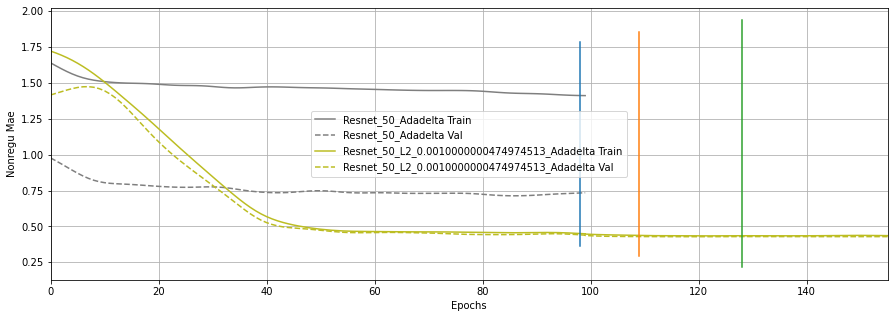

In [93]:
print(lr_record)

plt.figure(figsize=(15, 5))
plotter.plot(resnet_50_histories)
for i in range(len(epoch_record) - 1):
    plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

thay đổi lr không có ích gì, thử đổi sang optiizer khác xem sao

### TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir {logdir}/lr

In [ ]:
predictions = tf.data.Dataset.from_tensor_slices(model.predict(val_ds_prefetch)).batch(batch_size)

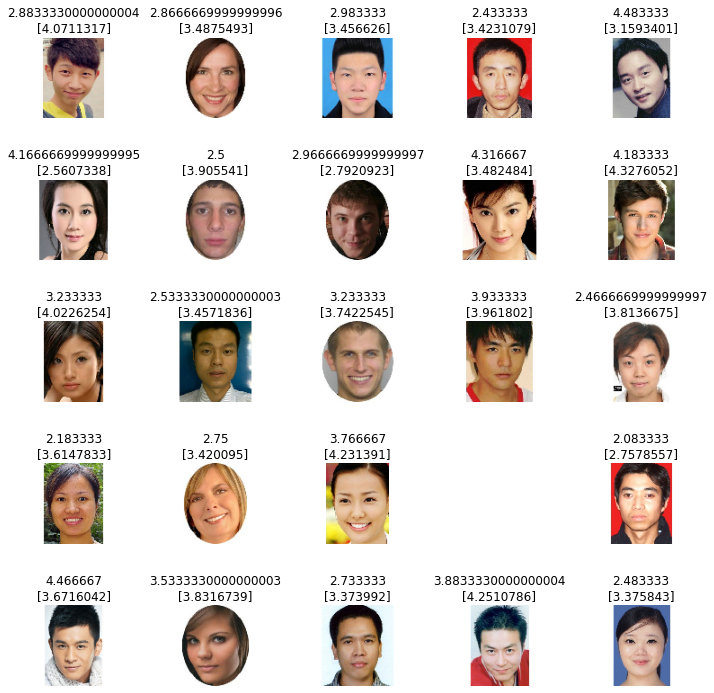

In [ ]:
plt.figure(figsize=(10, 10))
for images, true_scores in val_ds_prefetch.take(1):
    for pred_scores in predictions.take(1):
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i])
            plt.title('{}\n{}'.format(true_scores[i], pred_scores[i]))
            plt.tight_layout()
            plt.axis("off")